In [0]:
from google.colab import files
from IPython.display import Image
upload = files.upload()

LSTM with Conv1D

We aslo need to update the windowed_dataset helper function

In [0]:
model = tf.keras.models.Sequential([
  #Conv1D try to learn 32 filters, one dimensional convolution take 5 windows 
  # and multiply the window vout the value in window by the filter values, much the same way as Image convolution
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides = 1, padding = "causal",
                         activation = "relu", input_shape=[None,1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5), metrics=['mae'])# PUT YOUR LEARNING RATE HERE#, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)
                                                      

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  #Add expand_dim to help expansion of dataset
  series = tf.expand_dims(series, axis= -1)

  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

Then plot learning rate VS loss, choose learning rate as $1e^{-5}$, then retrain again, huge improvement for MAE.

Another observation is training longer. Even if MAE look flat at 500 epochs, if zoom in we can see slowly diminishing

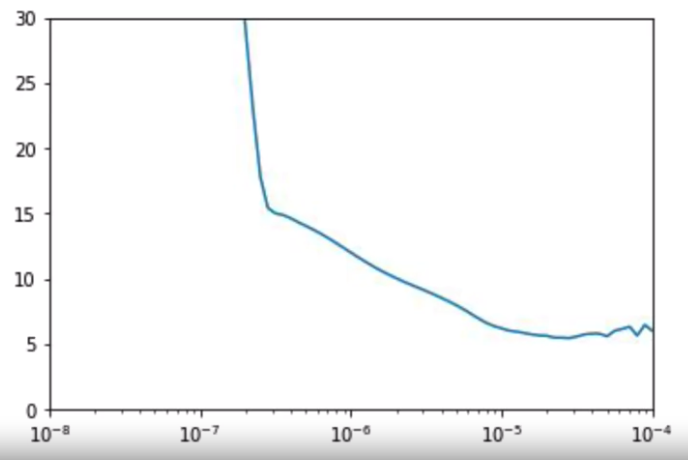

In [4]:
Image('lstm.png', width = 500)

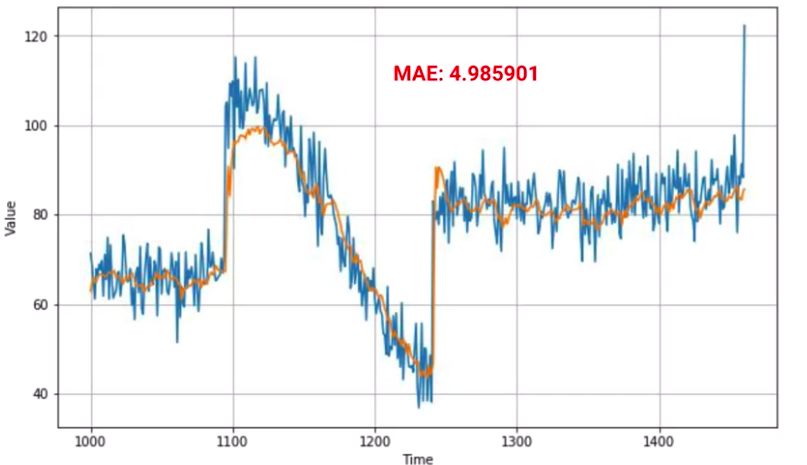

In [7]:
  Image('屏幕快照 2019-10-18 上午9.11.51.png', width = 500)

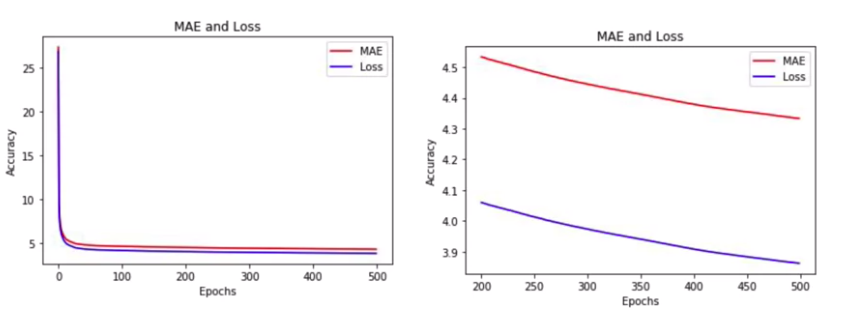

In [11]:
  Image('屏幕快照 2019-10-18 上午9.18.30.png', width = 600)

If we add second LSTM output hidden layer, it gives MAE on training lower and but overfit when plot on validation, and MAE go up. 

When plot loss VS MAE, find a lot of noise and instability in there. One common cause of small **spike like that is a small batch size introducing further random noise**. 

In [0]:
model = tf.keras.models.Sequential([
  #Conv1D try to learn 32 filters, one dimensional convolution take 5 windows 
  # and multiply the window vout the value in window by the filter values, much the same way as Image convolution
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides = 1, padding = "causal",
                         activation = "relu", input_shape=[None,1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

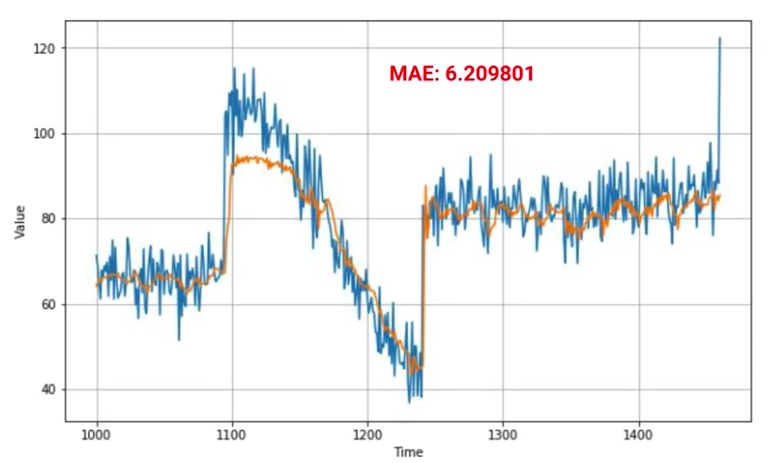

In [14]:
Image('屏幕快照 2019-10-18 上午9.24.43.png', width = 600)

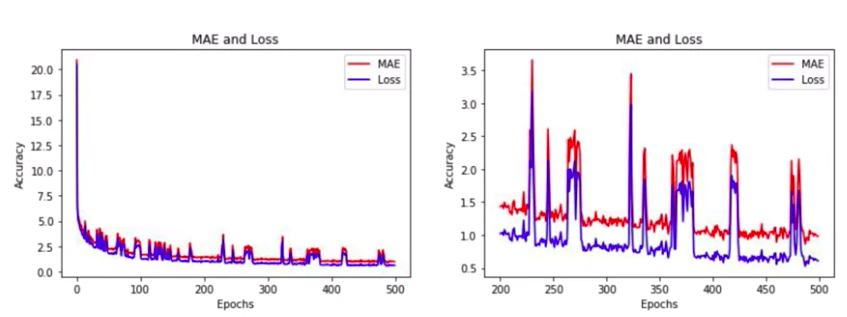

In [18]:
Image('屏幕快照 2019-10-18 上午9.25.53.png', width = 700)

When try batch size = 16

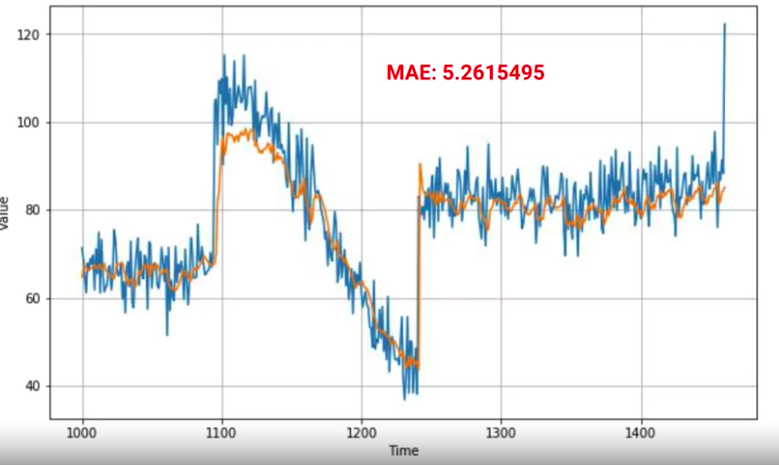

In [21]:
Image('屏幕快照 2019-10-18 上午9.28.49.png', width = 500)

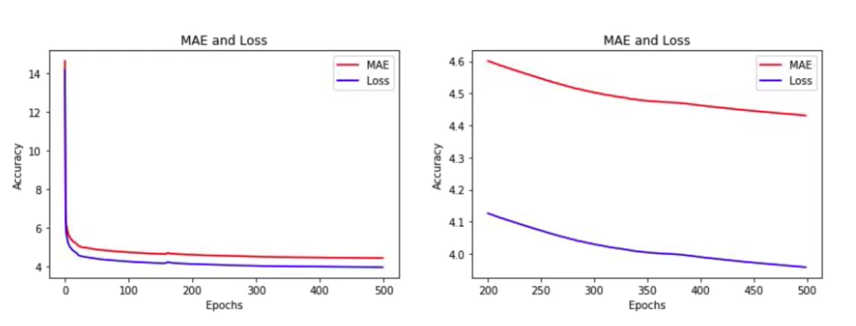

In [24]:
Image('屏幕快照 2019-10-18 上午9.29.32.png', width = 700)

## Sunspot Data


sample data example

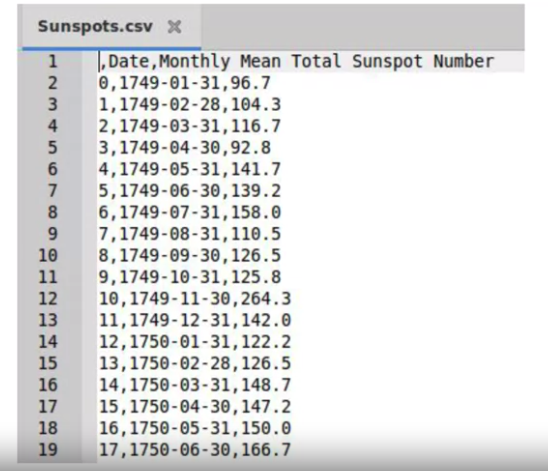

In [28]:
Image('屏幕快照 2019-10-18 上午9.37.53.png', width = 500)

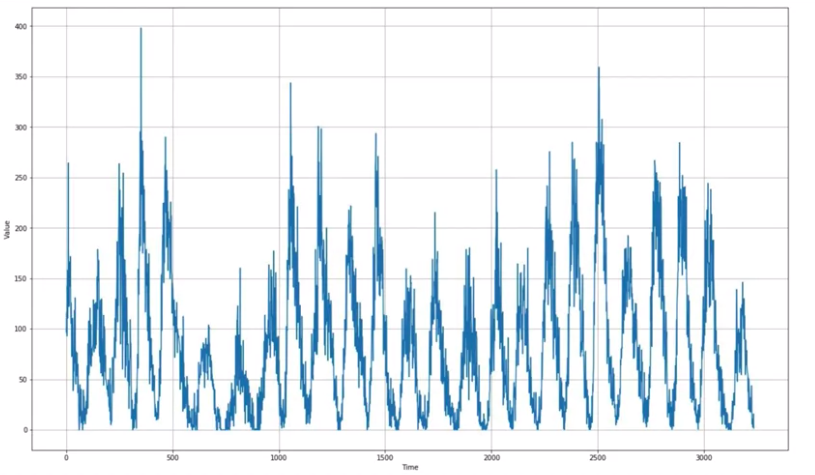

In [37]:
Image('屏幕快照 2019-10-18 上午10.41.03.png', width = 500)
#Raw Data plot, sunspots vs time

In [0]:
#Train on Simple DNN

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, input_shape = [window_size], activation = 'relu'),
  tf.keras.layers.Dense(19, activation = 'relu'),
  tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum = 0.9))# PUT YOUR LEARNING RATE HERE#, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=100,verbose=1)


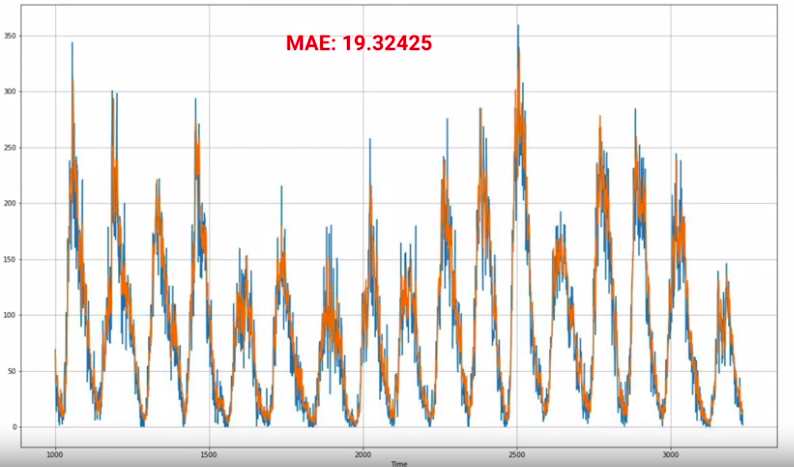

In [34]:
Image('屏幕快照 2019-10-18 上午10.33.00.png', width = 500)
#Eyeball looks good but have a larger MAE

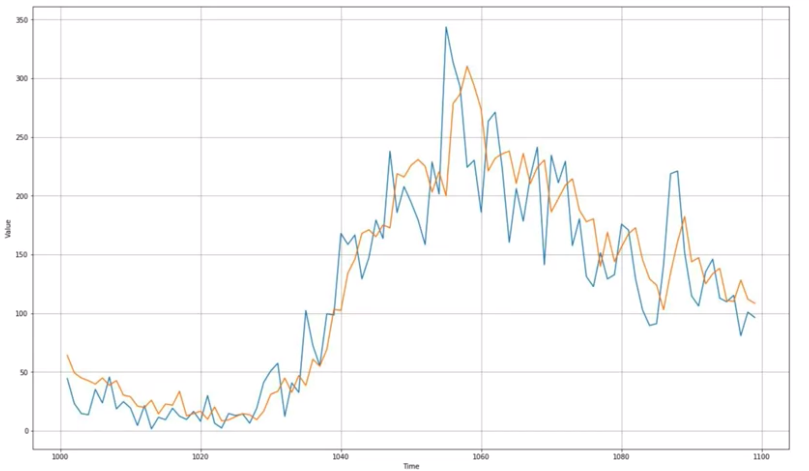

In [31]:
Image('屏幕快照 2019-10-18 上午10.31.49.png', width = 500)
#Zoom in the result

The problem could be window size. In above window_size = 20, our training window sizes are 20 x slice of data, 每一个数据都是一个month的, 20 is less than 2 years. But from observation of raw data set, seasonality is close to 11 years(Some sciences tell might be 22 years with different cycles interleaving with others). To retrain model with **window_size = 132** (11 yeras)

In [0]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 132 #change window size 30 to 132
batch_size = 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, input_shape = [window_size], activation = 'relu'),
  tf.keras.layers.Dense(19, activation = 'relu'),
  tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum = 0.9))# PUT YOUR LEARNING RATE HERE#, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=100,verbose=1)

We see MAE even worse. Increasing window_size don't work. We see window size is 11 years but we don't need full season in our window, if we zoom in window, we see 下图2. **It is a just typical time series. Some values later on related to earlier one but a lot of noise**. Maybe we don't need a huge window times to train. We change window_size to 30.

Before we have split data is 1000, training data is 1000 and validation data is 2500, Which is bad split! Let's use 3000 for training and 500 for validation, 

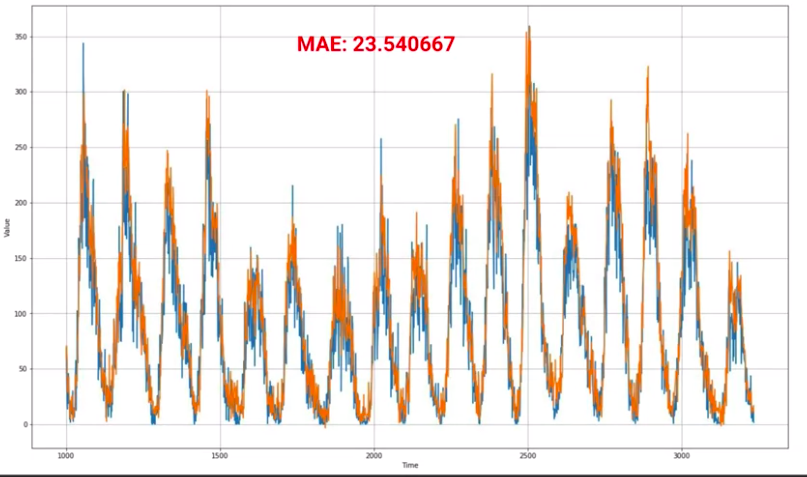

In [40]:
Image('屏幕快照 2019-10-18 上午10.44.23.png', width = 500)

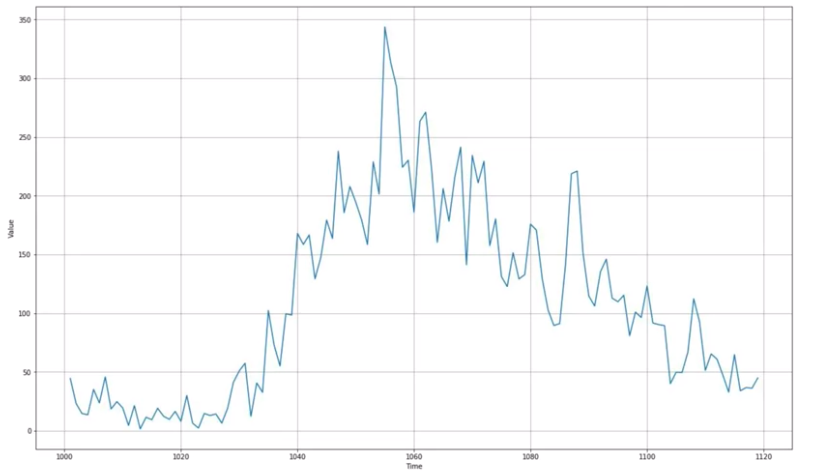

In [44]:
Image('屏幕快照 2019-10-18 上午10.47.01.png', width = 500)

In [0]:
split_time = 3000 #change split from 1000 to 3000
# 3000 for training , 500 for validation
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30 
batch_size = 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, input_shape = [window_size], activation = 'relu'),
  tf.keras.layers.Dense(19, activation = 'relu'),
  tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum = 0.9))# PUT YOUR LEARNING RATE HERE#, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=100,verbose=1)

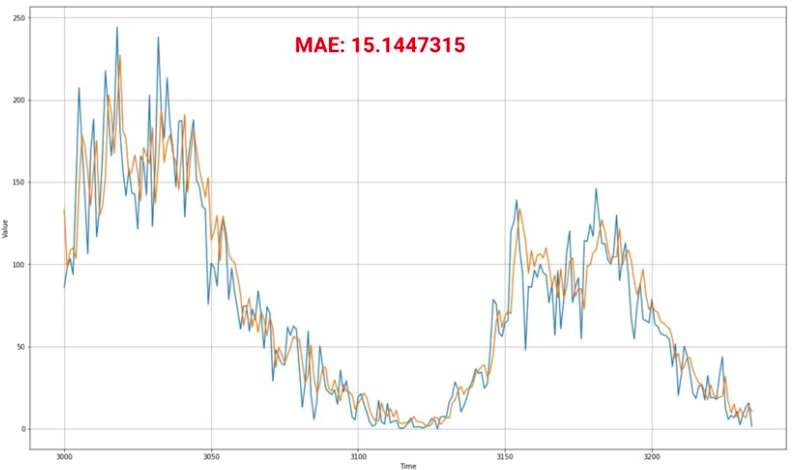

In [48]:
Image('屏幕快照 2019-10-18 上午10.51.59.png', width = 600)
#better than before

Then change Neural network design, before we have input is 30 and two hidden layers has 10, 10 neurons. Let's try 30 and 15 in hidden layers. We can see MAE decrease a little bit. It wasn't worth extra computing tiem for the extra neuron layers. 

In [0]:

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(30, input_shape = [window_size], activation = 'relu'), # change layers from 10 t0 30
  tf.keras.layers.Dense(15, activation = 'relu'), # change layers from 10 t0 15
  tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum = 0.9))# PUT YOUR LEARNING RATE HERE#, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=100,verbose=1)

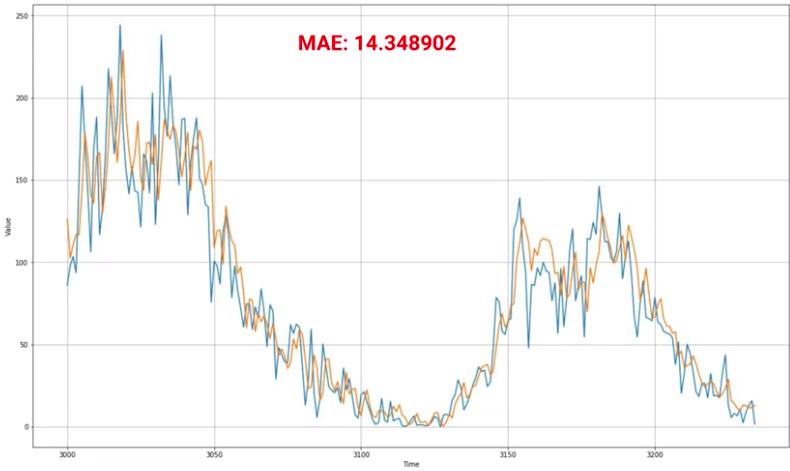

In [51]:
Image('屏幕快照 2019-10-18 上午10.56.30.png', width = 600)
# MAE 只减少一点

Let's switch hidden neuron to 10 and 10. And look at learning rate, which we see MAE decrease which is good

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, input_shape = [window_size], activation = 'relu'),
  tf.keras.layers.Dense(10, activation = 'relu'),
  tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum = 0.9))# change learning rate from 1e-5 to 1e-7
history = model.fit(dataset,epochs=100,verbose=1)

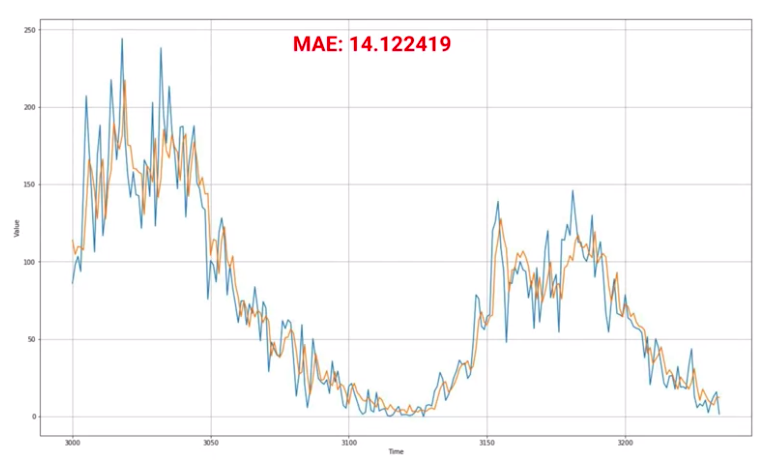

In [54]:
Image('屏幕快照 2019-10-18 上午11.00.12.png', width = 600)
#see MAE decrease

### Prediction

In [0]:
model.predict(series[3205:3235][np.newaxis])
# data total 3235 steps long, used for predict at the end of my dataset
# get 7.0773993
# data is at the end of 07-2018, predict at the end of 08-2018 whereas actual observation is 8.7


In [0]:
#With below setting, MAE down to 13.75
#Prediction is 8.13, closer to 8.7
split_time = 3000
window_size = 60

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, input_shape = [window_size], activation = 'relu'),
  tf.keras.layers.Dense(10, activation = 'relu'),
  tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum = 0.9))# change learning rate from 1e-5 to 1e-7
history = model.fit(dataset,epochs=100,verbose=1)

## Combine Tools Together

In [0]:
split_time = 3000
window_size = 60
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1, padding = "causal", activation="relu",
                         input_shape=[None,1])                                  
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(30, activation = 'relu'),
  tf.keras.layers.Dense(10, activation = 'relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch : 1e-8 * 10 **(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum = 0.9)
model.compile(loss="mse", optimizer=optimizer, metrics =["mae"])# change learning rate from 1e-5 to 1e-7
history = model.fit(train_set,epochs=100,verbose=1)

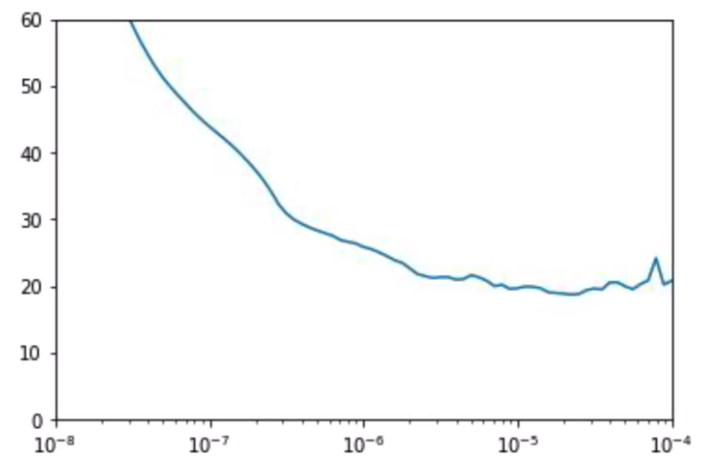

In [63]:
Image('屏幕快照 2019-10-18 上午11.35.40.png', width = 390)
#it suggest the best learning rate is 1e-5

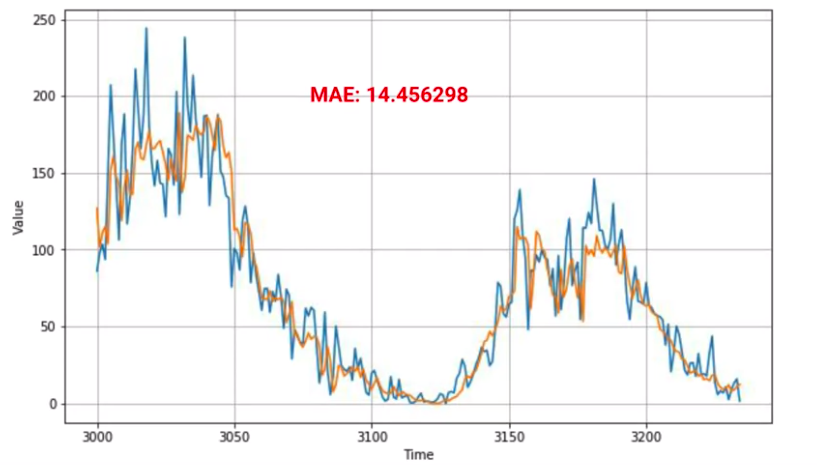

In [62]:
Image('屏幕快照 2019-10-18 下午12.13.45.png', width = 600)
#pretty good with low MAE

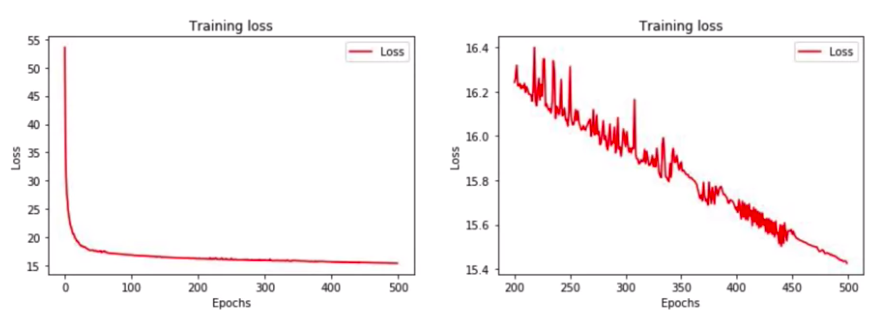

In [67]:
Image('屏幕快照 2019-10-18 下午12.14.57.png', width = 800)
#See loss function in training, could see lots of noise
# which could improve, so increase batch see to retrain

In [0]:
train_set = windowed_dataset(x_train, window_size, batch_size=256, shuffle_buffer_size) #increase batch size to retrain it


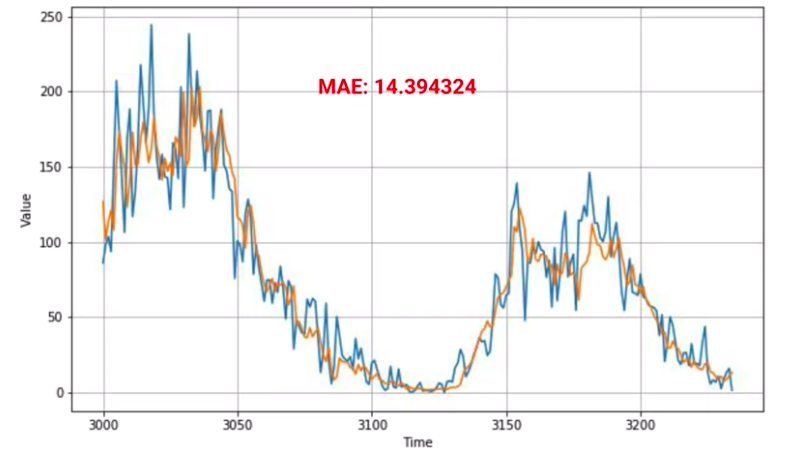

In [70]:
Image('屏幕快照 2019-10-18 下午12.17.27.png', width = 600)
#MAE improve little, show we are on right direction

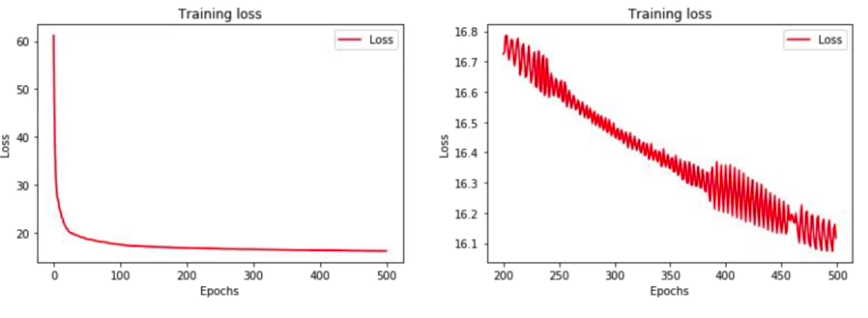

In [72]:
Image('屏幕快照 2019-10-18 下午12.17.33.png', width = 800)
#it is really noise at the end of training, very irregular looking wave,
#this suggest my large batch size looks good but maybe a little off
# it is not catastrophic, because flucation really small

In [0]:
# because training size is 3000, 256 maybe not be equally divided, change parameter to suit 
train_set = windowed_dataset(x_train, window_size, batch_size=250, shuffle_buffer_size) #increase batch size to retrain it

#aslo change filter size
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters = 64, kernel_size = 5, strides = 1, padding = "causal", activation="relu",
                         input_shape=[None,1])                                  
  tf.keras.layers.LSTM(60, return_sequences=True), #change LSTM to 60 instead of 32 or 64
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation = 'relu'),
  tf.keras.layers.Dense(10, activation = 'relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

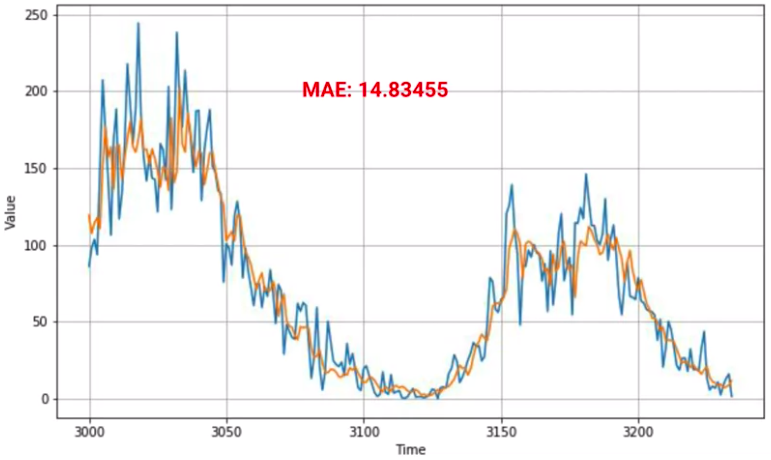

In [75]:
Image('屏幕快照 2019-10-18 下午12.24.46.png', width = 600)
# Score improve, showing on right direction

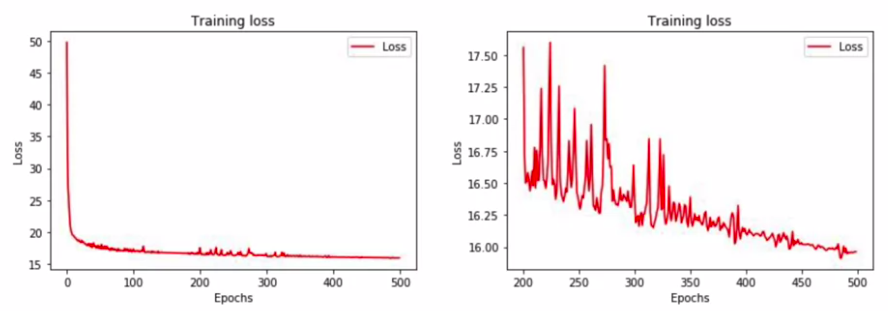

In [77]:
Image('屏幕快照 2019-10-18 下午12.25.59.png', width = 800)
# noise and loss increase a little bit, 

In [0]:
#decrease Batch size to 100
train_set = windowed_dataset(x_train, window_size, batch_size=256, shuffle_buffer_size) #increase batch size to retrain it

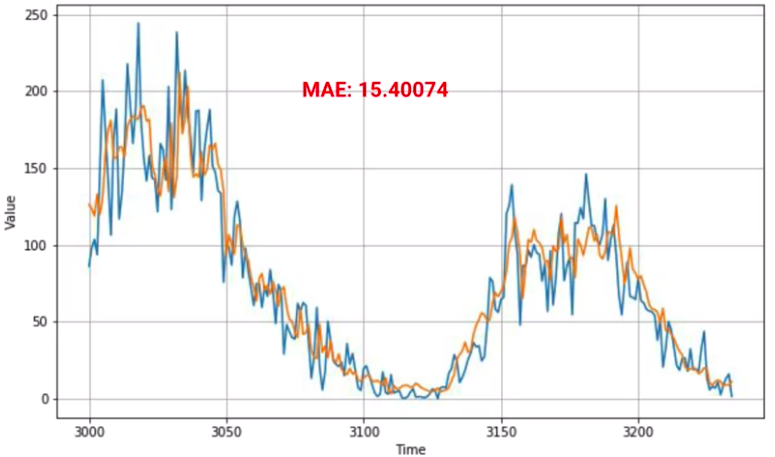

In [80]:
Image('屏幕快照 2019-10-18 下午12.27.48.png', width = 600)
# MAE go up a little bit. The projection go up much better in higher peaks than earlier but overall accuracy goes down

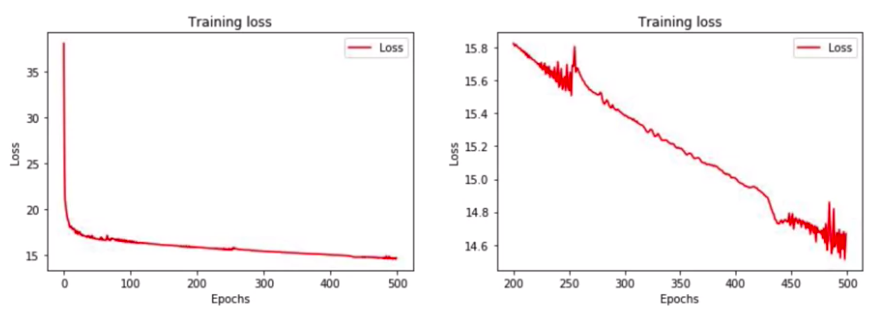

In [83]:
Image('屏幕快照 2019-10-18 下午12.29.31.png', width = 800)
# Loss has smoothed but except for a couple of large blips